In [2]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [4]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs, stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure

In [5]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [7]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# stack runs for each model
x, y, vars = stack_runs(x,y,vars,time_period=33,lon_size=lon_size,lat_size=lat_size,dtype=dtype)

# convert all data to pytorch tensors with precision float32
# x = {key: elt.to(torch.float16) for key, elt in x.items()}
# y = {key: elt.to(torch.float16) for key, elt in y.items()}
# vars = {key: elt.to(torch.float16) for key, elt in vars.items()}

# stack runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [10]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33,dtype=dtype)

In [18]:
from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, train_robust_weights_model, compute_weights


In [19]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

: 

: 

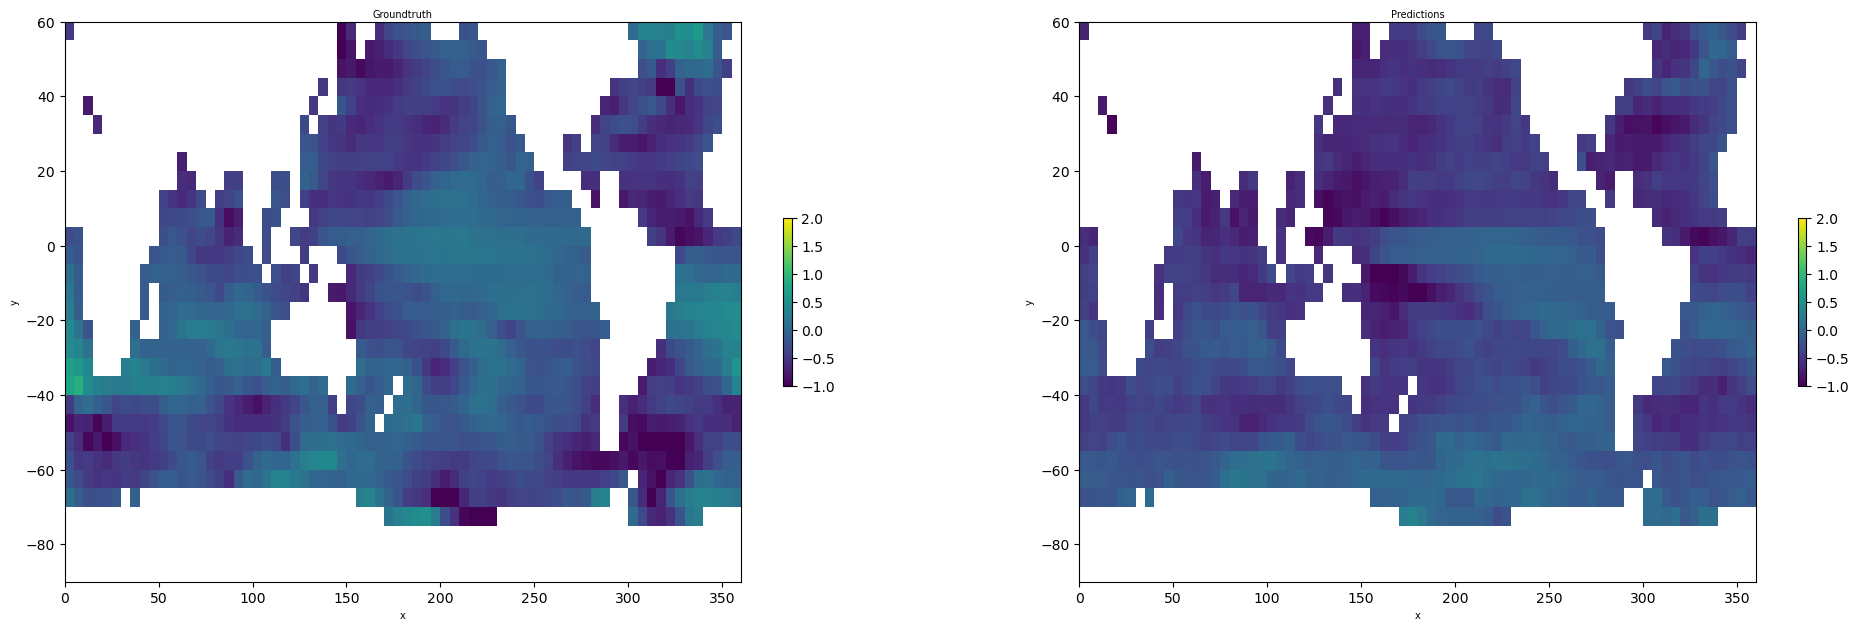

In [8]:
from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred

plot_gt_vs_pred(y_test,x_test,W_ridge,notnan_idx,nan_idx,lon_grid,lat_grid,time_idx=10)

In [9]:
w_robust  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,\
                                                       rank=10,lambda_=100.0,mu_=1000.0,\
                                                       lr=1e-5,nb_iterations=20,dtype=dtype)

/tmp/ipykernel_11503/1383609421.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)


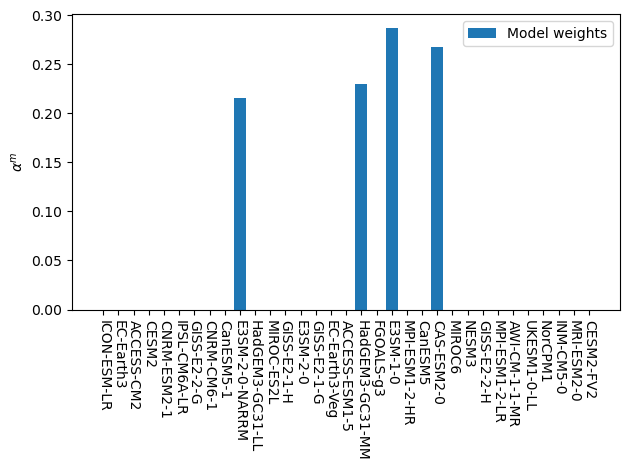

In [10]:
weights = compute_weights(training_models,w_robust,x,y,notnan_idx,lambda_=100.0,mu_=1000.0)

# plot the weights
    
################# plot the rmse #################
fig, ax = plt.subplots()
ax.bar(training_models, list(weights.values()),label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

In [11]:
# w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
#                                          lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                          method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
#                                          lr=1e-5,nb_gradient_iterations=5,verbose=True)

In [12]:
lambda_tmp = 100.0
mu_tmp = 1000.0
rank_tmp = 10

W_ridge, rmse_mean_ridge, training_loss_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                                    method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

Loss function:  2909511.2115751994


RuntimeError: Index put requires the source and destination dtypes match, got Float for the destination and Double for the source.

In [13]:
W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
                                                                            lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                            method='rrr',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                            lr=1e-5,nb_gradient_iterations=50,verbose=True)

RMSE (mean) on model  ICON-ESM-LR  :  1.0970705126407285
RMSE (mean) on model  EC-Earth3  :  0.3143453977299302
RMSE (mean) on model  CMCC-CM2-SR5  :  0.47183696632057043
RMSE (mean) on model  ACCESS-CM2  :  0.5207611540722334
RMSE (mean) on model  CESM2  :  0.4528270241097713
RMSE (mean) on model  CNRM-ESM2-1  :  0.2751920902416996
RMSE (mean) on model  IPSL-CM6A-LR  :  0.2885410787091417
RMSE (mean) on model  GISS-E2-2-G  :  0.19252574983105125
RMSE (mean) on model  CNRM-CM6-1  :  0.21596118783035062
RMSE (mean) on model  CanESM5-1  :  0.4887362006842222
RMSE (mean) on model  E3SM-2-0-NARRM  :  1.6358931927614877
RMSE (mean) on model  HadGEM3-GC31-LL  :  0.4184215793047018
RMSE (mean) on model  MIROC-ES2L  :  0.17858426921742213
RMSE (mean) on model  GISS-E2-1-H  :  0.24213190287054312
Sum of weights ==1 :  1.0


In [ ]:
W_robust, rmse_mean_robust, training_loss_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                                    method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=100,verbose=True)

Iteration  0 : Loss function :  49017.2578125
Iteration  1 : Loss function :  41395.16796875
Iteration  2 : Loss function :  36577.234375
Iteration  3 : Loss function :  32731.56640625
Iteration  4 : Loss function :  29262.19921875
Iteration  5 : Loss function :  26108.001953125
Iteration  6 : Loss function :  23293.544921875
Iteration  7 : Loss function :  20818.2890625
Iteration  8 : Loss function :  18687.21875
Iteration  9 : Loss function :  17019.27734375
Iteration  10 : Loss function :  15901.8701171875
Iteration  11 : Loss function :  15148.2294921875
Iteration  12 : Loss function :  14610.3291015625
Iteration  13 : Loss function :  14200.3359375
Iteration  14 : Loss function :  13872.1240234375
Iteration  15 : Loss function :  13600.8701171875
Iteration  16 : Loss function :  13371.513671875
Iteration  17 : Loss function :  13173.8935546875
Iteration  18 : Loss function :  13000.8916015625
Iteration  19 : Loss function :  12847.5673828125
Iteration  20 : Loss function :  12710.

/home/vcohen/cope/src/algorithms.py:232: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE (mean) on model  ICON-ESM-LR  :  0.6377806124931545
Iteration  0 : Loss function :  49017.26171875
Iteration  1 : Loss function :  41395.9453125
Iteration  2 : Loss function :  36621.84765625
Iteration  3 : Loss function :  33312.27734375
Iteration  4 : Loss function :  30806.623046875
Iteration  5 : Loss function :  28449.486328125
Iteration  6 : Loss function :  26667.134765625
Iteration  7 : Loss function :  24581.650390625
Iteration  8 : Loss function :  23065.4609375
Iteration  9 : Loss function :  21739.451171875
Iteration  10 : Loss function :  20596.109375
Iteration  11 : Loss function :  19581.912109375
Iteration  12 : Loss function :  18678.587890625
Iteration  13 : Loss function :  17886.65625
Iteration  14 : Loss function :  17213.736328125
Iteration  15 : Loss function :  16657.927734375
Iteration  16 : Loss function :  16203.115234375
Iteration  17 : Loss function :  15827.4755859375
Iteration  18 : Loss function :  15511.109375
Iteration  19 : Loss function :  15239

In [ ]:
W_robust_rrr, rmse_mean_robust_rrr, training_loss_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                                    method='robust',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


######################## compute the ridge rrr ######################
rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# worst loo Ridge
worst_loo_rrr = np.max(rmse_rrr_tmp)
mean_loo_rrr = np.mean(rmse_rrr_tmp)


# quantile 95, 90, 75
q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


######################## compute the robust regression ######################
rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# worst loo Ridge
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)


# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

######################## compute the robust regression with low rank constraint ######################
rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# worst loo Ridge
worst_loo_robust_rrr = np.max(rmse_robust_rrr)
mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# quantile 95, 90, 75
q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


print("======= Statistics ========")
print("\n")
print("          Ridge   RR-Lr   Robust  Robust-Lr")
print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

In [ ]:
# w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,\
#                                                            lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                                            method='robust', rank=None, lambda_range=torch.tensor([100.0]), mu_range=torch.tensor([1000.0]),\
#                                                            lr=1e-5,nb_gradient_iterations=100,verbose=True)